https://colab.research.google.com/drive/1Hh63kIBAiBw3Hho--BvfdUWLu-ysMFF0?usp=sharing

위 코드를 현재 버전에 맞게 수정

In [ ]:
!pip install emoji==0.6.0
!pip install transformers
!pip install soynlp
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import transformers
import emoji
import soynlp
import pytorch_lightning

In [ ]:
import os
import pandas as pd

from pprint import pprint

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ExponentialLR

from pytorch_lightning import LightningModule, Trainer, seed_everything

from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import re
import emoji
from soynlp.normalizer import repeat_normalize

In [ ]:

args = {
    'random_seed': 42,
    'pretrained_model': 'beomi/KcELECTRA-base',
    'pretrained_tokenizer': '',
    'batch_size': 32,
    'lr': 5e-6,
    'epochs': 10,
    'max_length': 25,
    'train_data_path': "/content/drive/MyDrive/train_set_fold2.txt",  # Train Dataset file          # fix
    # 'train_data2_path': "/content/drive/MyDrive/train_set2.txt",  # Train Dataset file          # fix
    'val_data_path': "/content/drive/MyDrive/val_set_fold2.txt",  # Validation Dataset file        # fix
    # 'val_data2_path': "/content/drive/MyDrive/val_set2.txt",  # Validation Dataset file        # fix
    'data_path': "/content/drive/MyDrive/data.txt",
    'test_mode': False,
    'optimizer': 'AdamW',
    'lr_scheduler': 'exp',
    'fp16': True,
    'tpu_cores': 0,
    'cpu_workers': os.cpu_count(),
}

In [ ]:
args

{'random_seed': 42,
 'pretrained_model': 'beomi/KcELECTRA-base',
 'pretrained_tokenizer': '',
 'batch_size': 32,
 'lr': 5e-06,
 'epochs': 10,
 'max_length': 25,
 'train_data_path': '/content/drive/MyDrive/train_set_fold5.txt',
 'val_data_path': '/content/drive/MyDrive/val_set_fold5.txt',
 'data_path': '/content/drive/MyDrive/data.txt',
 'test_mode': False,
 'optimizer': 'AdamW',
 'lr_scheduler': 'exp',
 'fp16': True,
 'tpu_cores': 0,
 'cpu_workers': 2}

In [ ]:
from pytorch_lightning.utilities.types import EVAL_DATALOADERS


class Model(LightningModule):

    def __init__(self, **kwargs):
        super().__init__()
        self.save_hyperparameters()

        self.training_step_outputs = []
        self.validation_step_outputs = []

        self.training_outputs = []
        self.validation_outputs = []
        self.training_loss = []
        self.validation_loss = []

        self.clsfier = AutoModelForSequenceClassification.from_pretrained(self.hparams.pretrained_model, num_labels=4)
        self.tokenizer = AutoTokenizer.from_pretrained(
            self.hparams.pretrained_tokenizer
            if self.hparams.pretrained_tokenizer
            else self.hparams.pretrained_model
        )

    def forward(self, **kwargs):
        return self.clsfier(**kwargs)
    
    def step(self, batch, batch_idx):
        data, labels = batch
        output = self(input_ids=data, labels=labels)

        loss = output.loss
        logits = output.logits

        preds = logits.argmax(dim=-1)

        y_true = list(labels.cpu().numpy())
        y_pred = list(preds.cpu().numpy())

        return {
            'loss': loss,
            'y_true': y_true,
            'y_pred': y_pred
        }
    
    def training_step(self, batch, batch_idx):
        
        ret = self.step(batch, batch_idx)
        self.training_step_outputs.append(ret)
        return ret
    
    def validation_step(self, batch, batch_idx):
        
        ret = self.step(batch, batch_idx)
        self.validation_step_outputs.append(ret)
        return ret
    
    def epoch_end(self, outputs, state='train'):
        loss = torch.tensor(0, dtype=torch.float)
        if state=='val': print(outputs)
        for i in outputs:
            loss += i['loss'].cpu().detach()
        loss = loss / len(outputs)

        y_true = []
        y_pred = []
        for i in outputs:
            y_true += i['y_true']
            y_pred += i['y_pred']

        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average='macro')
        rec = recall_score(y_true, y_pred, average='macro')
        f1 = f1_score(y_true, y_pred, average='macro')

        if state =='train':
          self.training_outputs.append({'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1})
          self.training_loss.append(loss)
        elif state == 'val':
          self.validation_outputs.append({'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1})
          self.validation_loss.append(loss)

        self.log(state+'_loss', float(loss), on_epoch=True, prog_bar=True)
        self.log(state+'_acc', acc, on_epoch=True, prog_bar=True)
        self.log(state+'_precision', prec, on_epoch=True, prog_bar=True)
        self.log(state+'_recall', rec, on_epoch=True, prog_bar=True)
        self.log(state+'_f1', f1, on_epoch=True, prog_bar=True)
        print(f'[Epoch {self.trainer.current_epoch} {state.upper()}] Loss: {loss}, Acc: {acc}, Prec: {prec}, Rec: {rec}, F1: {f1}')
        return {'loss': loss}     

    def on_train_epoch_end(self): # fix
        self.epoch_end(self.training_step_outputs, state='train')
        self.training_step_outputs.clear()

    def on_validation_epoch_end(self): # fix
        self.epoch_end(self.validation_step_outputs, state='val')   
        self.validation_step_outputs.clear()

    def configure_optimizers(self):
        if self.hparams.optimizer == 'AdamW':
            optimizer = AdamW(self.parameters(), lr=self.hparams.lr)
        elif self.hparams.optimizer == 'AdamP':
            from adamp import AdamP
            optimizer = AdamP(self.parameters(), lr=self.hparams.lr)
        else:
            raise NotImplementedError('Only AdamW and AdamP is Supported!')
        if self.hparams.lr_scheduler == 'cos':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2)
        elif self.hparams.lr_scheduler == 'exp':
            scheduler = ExponentialLR(optimizer, gamma=0.5)
        else:
            raise NotImplementedError('Only cos and exp lr scheduler is Supported!')
        return {
            'optimizer': optimizer,
            'scheduler': scheduler,
        }
    
    def read_data(self, path):
        if path.endswith('xlsx'):
            return pd.read_excel(path)
        elif path.endswith('csv'):
            return pd.read_csv(path)
        elif path.endswith('tsv') or path.endswith('txt'):
            return pd.read_csv(path, sep='\t')
        else:
            raise NotImplementedError('Only Excel(xlsx)/Csv/Tsv(txt) are Supported')
        
    def clean(self, x):
        emojis = ''.join(emoji.UNICODE_EMOJI.keys())
        pattern = re.compile(f'[^ .,?!/@$%~％·∼()\x00-\x7Fㄱ-힣{emojis}]+')
        url_pattern = re.compile(
            r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)')
        x = pattern.sub(' ', x)
        x = url_pattern.sub('', x)
        x = x.strip()
        x = repeat_normalize(x, num_repeats=2)
        return x

    def encode(self, x, **kwargs):
        return self.tokenizer.encode(
            self.clean(str(x)),
            padding='max_length',
            max_length = self.hparams.max_length,
            truncation=True,
            **kwargs,
        )
    
    def preprocess_dataframe(self, df):
        df['sentence'] = df['sentence'].map(self.encode)
        return df
    
    def dataloader(self, path, shuffle=False):
        df = self.read_data(path)
        df = self.preprocess_dataframe(df)

        dataset = TensorDataset(
            torch.tensor(df['sentence'].to_list(), dtype=torch.long),
            torch.tensor(df['label'].to_list(), dtype=torch.long)
        )
        return DataLoader(
            dataset,
            batch_size=self.hparams.batch_size * 1 if not self.hparams.tpu_cores else self.hparams.tpu_cores,
            shuffle=shuffle,
            num_workers=self.hparams.cpu_workers
        )
    
    def train_dataloader(self):
        return self.dataloader(self.hparams.train_data_path, shuffle=True)
    
    def val_dataloader(self):
        return self.dataloader(self.hparams.val_data_path, shuffle=True)

    def data_dataloader(self):
        return self.dataloader(self.hparams.data_path, shuffle=True)


In [ ]:
import pandas as pd

# 텍스트 파일 경로
file_path = '/content/drive/MyDrive/data.txt'

# 파일 읽기
with open(file_path, 'r') as file:
    lines = file.readlines()

# 데이터프레임 생성
data = {'sentence': [], 'label': []}  

for line in lines[1:]:  # 첫 번째 줄(헤더 줄)을 제외하고 반복
    values = line.strip().split('\t')  # 탭 문자로 분리
    # print(len(values))
    # print(values)
    data['sentence'].append(values[1])
    data['label'].append(values[2])

data = pd.DataFrame(data)
data = data.sample(frac=1).reset_index(drop=True)
# 데이터프레임 출력
print(data)

                                                sentence label
0                                하....오랜만에 들어왔는데 힘드네요...     0
1                          따돌림 당한 뒤로 혼자서 밥먹어야 해서 너무 외로워.     1
2                    4년을 사귄사이고 정말 서로 사랑했고여자의 변심때문에 헤어졌고.     0
3                          아내가 자꾸 친구들 앞에서 내 기를 죽여서 화가 나.     3
4                       나 때문에 직장 동료가 누명을 쓰게 되었어. 너무 미안해.     1
...                                                  ...   ...
57858                  이번 시험에서 좋은 점수를 못 받아서 아버지께 매를 맞았어.     3
57859              회사에 다니고 있는데 직장에서의 대인 관계 때문에 요즘 아주 슬퍼.     0
57860                      회사에서 스트레스를 너무 많이 받아서 몸이 안 좋아.     3
57861          나 취업이 잘 안 돼서 너무 슬퍼. 지원은 많이 하는데 다 중도에 탈락해.     0
57862  얼마 전에 지수라고 전학 온 애가 있거든? 걔가 내 친구들과 오해를 풀어줘서 화해하...     2

[57863 rows x 2 columns]


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

sen, label = list(), list()
for i in range(len(data)):
    sen.append(data.loc[i,"sentence"])
    label.append(data.loc[i,"label"])
print("Whole Datasets: ",len(sen), len(label))
x_train = sen
y_train = label
# _, x_train, _, y_train = train_test_split(sen, label, test_size=1)
# print("20% of Data: ",len(x_train), len(y_train))

from sklearn.model_selection import StratifiedKFold, KFold
import pandas as pd

# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# fold_x_train, fold_y_train, fold_x_test, fold_y_test = [], [], [], []

# for i, (train_index, test_index) in enumerate(skf.split(x_train, y_train)):
#     print(f"Fold {i+1}:")
#     print(f"  Train: index={train_index}")
#     print(f"  Test:  index={test_index}")
#     fold_x_train.append([x_train[idx] for idx in train_index])
#     fold_y_train.append([y_train[idx] for idx in train_index])
#     fold_x_test.append([x_train[idx] for idx in test_index])
#     fold_y_test.append([y_train[idx] for idx in test_index])

# train_name, test_name = [], []
# for i in range(5):
#     train_name.append("fold_train_" + str(i+1))
#     test_name.append("fold_test_" + str(i+1))

# for i in range(5):
#     train_set = pd.DataFrame(list(zip(fold_x_train[i], fold_y_train[i])))
#     train_set.to_csv(train_name[i] + ".txt", sep='\t', index=False)
#     test_set = pd.DataFrame(list(zip(fold_x_test[i], fold_y_test[i])))
#     test_set.to_csv(test_name[i] + ".txt", sep='\t', index=False)

skf = StratifiedKFold(n_splits=5)
# skf.get_n_splits(x_train, y_train)
skf.get_n_splits(sen, label)
fold_x_train, fold_y_train, fold_x_test, fold_y_test = list(), list(),list(),list()

for i, (train_index, test_index) in enumerate(skf.split(x_train, y_train)):
    print(f"Fold {i+1}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")
    fold_x_train.append(np.array(x_train)[train_index])
    fold_y_train.append(np.array(y_train)[train_index])
    fold_x_test.append(np.array(x_train)[test_index])
    fold_y_test.append(np.array(y_train)[test_index])

train_name, test_name = list(),list()
for i in range(5):
    train_name.append("fold_train_"+str(i+1))
    test_name.append("fold_test_"+str(i+1))

for i in range(5):
    train_set = pd.DataFrame([x for x in zip(fold_x_train[i], fold_y_train[i])])
    train_set.to_csv(train_name[i]+".txt",sep='\t')
    test_set = pd.DataFrame([x for x in zip(fold_x_test[i], fold_y_test[i])])
    test_set.to_csv(test_name[i]+".txt",sep='\t')

Whole Datasets:  57863 57863
Fold 1:
  Train: index=[11444 11445 11447 ... 57860 57861 57862]
  Test:  index=[    0     1     2 ... 11655 11656 11664]
Fold 2:
  Train: index=[    0     1     2 ... 57860 57861 57862]
  Test:  index=[11444 11445 11447 ... 23401 23402 23403]
Fold 3:
  Train: index=[    0     1     2 ... 57860 57861 57862]
  Test:  index=[22811 22812 22816 ... 34954 34955 34956]
Fold 4:
  Train: index=[    0     1     2 ... 57860 57861 57862]
  Test:  index=[34251 34263 34265 ... 46416 46424 46432]
Fold 5:
  Train: index=[    0     1     2 ... 46416 46424 46432]
  Test:  index=[46133 46141 46145 ... 57860 57861 57862]


In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filename='epoch{epoch}-val_acc{val_acc:.4f}',
    monitor='val_acc',
    save_top_k=3,
    mode='max',
    auto_insert_metric_name=False,
)

In [ ]:
import os
folder_path = "/content/drive/MyDrive/"

for i in range(5):
    print(f"Fold {i+1}:")
    x_train, y_train = fold_x_train[i], fold_y_train[i]
    x_test, y_test = fold_x_test[i], fold_y_test[i]
    print(x_train, y_train)
    print(x_test, y_test)

    header_row = pd.DataFrame([["sentence", "label"]], columns=["sentence", "label"])
    
    df_train = pd.DataFrame(list(zip(x_train, y_train)), columns=["sentence", "label"])
    train_filename = os.path.join(folder_path, f"train_set_fold{i+1}.txt")
    df_train.to_csv(train_filename, sep='\t', index=False, header=True)

    df_test = pd.DataFrame(list(zip(x_test, y_test)), columns=["sentence", "label"])
    test_filename = os.path.join(folder_path, f"val_set_fold{i+1}.txt")
    df_test.to_csv(test_filename, sep='\t', index=False, header=True)
    
    # print("Using PyTorch Ver", torch.__version__)
    # print("Fix Seed:", args['random_seed'])
    # seed_everything(args['random_seed'])
    # model = Model(**args)

    # print(":: Start Training ::")
    # trainer = Trainer(
    #     callbacks=[checkpoint_callback],
    #     max_epochs=args['epochs'],
    #     fast_dev_run=args['test_mode'],
    #     num_sanity_val_steps=None if args['test_mode'] else 0,
    #     # For GPU Setup
    #     deterministic=torch.cuda.is_available(),
    #     accelerator="gpu",
    #     precision=16 if args['fp16'] and torch.cuda.is_available() else 32,
    #     # For TPU Setup
    #     # tpu_cores=args['tpu_cores'] if args['tpu_cores'] else None,
    # )
    # trainer.fit(model)

Fold 1:
['대학교 동창을 오랜만에 만났는데 내가 가고 싶었던 기업에서 일을 하고 있어서 부러웠어.'
 '뭐라고 대답해야 면접관들이 안좋게 보지 않을까요' '오늘 학교에서 진로 특강을 들었어.' ...
 '회사에서 스트레스를 너무 많이 받아서 몸이 안 좋아.'
 '나 취업이 잘 안 돼서 너무 슬퍼. 지원은 많이 하는데 다 중도에 탈락해.'
 '얼마 전에 지수라고 전학 온 애가 있거든? 걔가 내 친구들과 오해를 풀어줘서 화해하게 되었어.'] ['1' '1' '1' ... '3' '0' '2']
['하....오랜만에 들어왔는데 힘드네요...' '따돌림 당한 뒤로 혼자서 밥먹어야 해서 너무 외로워.'
 '4년을 사귄사이고 정말 서로 사랑했고여자의 변심때문에 헤어졌고.' ...
 '영국이 우파에 손들어 브릭시트 일어나고 트럼프가 당선되는걸 절대 반대한 좌빨언론사들!' '엄마를 보기가 싫어.'
 '두 연 놈을 단두대에 묶어라'] ['0' '1' '0' ... '3' '3' '3']
Fold 2:
['하....오랜만에 들어왔는데 힘드네요...' '따돌림 당한 뒤로 혼자서 밥먹어야 해서 너무 외로워.'
 '4년을 사귄사이고 정말 서로 사랑했고여자의 변심때문에 헤어졌고.' ... '회사에서 스트레스를 너무 많이 받아서 몸이 안 좋아.'
 '나 취업이 잘 안 돼서 너무 슬퍼. 지원은 많이 하는데 다 중도에 탈락해.'
 '얼마 전에 지수라고 전학 온 애가 있거든? 걔가 내 친구들과 오해를 풀어줘서 화해하게 되었어.'] ['0' '1' '0' ... '3' '0' '2']
['대학교 동창을 오랜만에 만났는데 내가 가고 싶었던 기업에서 일을 하고 있어서 부러웠어.'
 '뭐라고 대답해야 면접관들이 안좋게 보지 않을까요' '오늘 학교에서 진로 특강을 들었어.' ... '해줄 욕두 없다~~!!'
 '이 시국에 짱국을 가?' '미친것들!!'] ['1' '1' '1' ... '3' '3' '3']
Fold 3:
['하....오랜만에 들어왔는데 힘드네요...' '따돌림 당한 뒤로 혼자서

In [ ]:
## 여기 위에까지 CV

print("Using PyTorch Ver", torch.__version__)
print("Fix Seed:", args['random_seed'])
seed_everything(args['random_seed'])
model = Model(**args)

print(":: Start Training ::")
trainer = Trainer(
    callbacks=[checkpoint_callback],
    max_epochs=args['epochs'],
    fast_dev_run=args['test_mode'],
    num_sanity_val_steps=None if args['test_mode'] else 0,
    # For GPU Setup
    deterministic=torch.cuda.is_available(),
    accelerator="gpu",
    precision=16 if args['fp16'] and torch.cuda.is_available() else 32,
    # For TPU Setup
    # tpu_cores=args['tpu_cores'] if args['tpu_cores'] else None,
)
trainer.fit(model)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


Using PyTorch Ver 2.0.1+cu118
Fix Seed: 42


Some weights of the model checkpoint at beomi/KcELECTRA-base were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.out_proj.bias', 'classifier

:: Start Training ::


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[{'loss': tensor(1.1541, device='cuda:0'), 'y_true': [0, 2, 0, 1, 0, 0, 2, 1, 1, 0, 0, 2, 1, 0, 2, 1, 3, 0, 2, 0, 3, 2, 1, 3, 2, 3, 0, 3, 2, 0, 1, 1], 'y_pred': [0, 3, 2, 1, 3, 0, 1, 0, 2, 1, 0, 2, 3, 0, 2, 2, 3, 0, 2, 0, 3, 2, 2, 1, 2, 1, 0, 1, 2, 1, 1, 1]}, {'loss': tensor(0.8058, device='cuda:0'), 'y_true': [0, 0, 2, 0, 1, 3, 3, 3, 1, 1, 3, 2, 0, 2, 2, 1, 0, 1, 2, 0, 0, 3, 2, 0, 1, 2, 1, 2, 2, 1, 1, 0], 'y_pred': [0, 0, 2, 1, 1, 0, 1, 1, 0, 1, 3, 2, 0, 2, 1, 2, 1, 1, 2, 3, 1, 3, 2, 0, 1, 0, 1, 1, 2, 0, 1, 1]}, {'loss': tensor(0.6248, device='cuda:0'), 'y_true': [3, 3, 3, 0, 1, 0, 1, 3, 1, 1, 2, 0, 1, 3, 2, 1, 0, 3, 2, 1, 0, 1, 3, 0, 3, 1, 0, 3, 3, 0, 3, 0], 'y_pred': [2, 3, 0, 0, 3, 0, 0, 3, 1, 1, 2, 0, 1, 3, 2, 1, 1, 3, 2, 1, 1, 1, 0, 0, 3, 1, 0, 1, 3, 0, 3, 1]}, {'loss': tensor(0.6923, device='cuda:0'), 'y_true': [0, 0, 1, 0, 0, 0, 1, 3, 3, 1, 2, 2, 0, 1, 2, 3, 0, 1, 3, 3, 1, 0, 3, 1, 1, 3, 1, 3, 2, 2, 1, 0], 'y_pred': [2, 1, 1, 0, 0, 1, 1, 3, 0, 1, 2, 2, 0, 1, 2, 3, 0, 1, 1, 1, 1

Validation: 0it [00:00, ?it/s]

[{'loss': tensor(0.6908, device='cuda:0'), 'y_true': [1, 0, 3, 0, 0, 2, 3, 3, 3, 1, 2, 3, 2, 0, 3, 1, 2, 0, 1, 0, 1, 0, 0, 2, 2, 3, 3, 1, 2, 2, 0, 1], 'y_pred': [1, 1, 3, 0, 0, 2, 3, 3, 3, 0, 2, 3, 2, 0, 0, 1, 2, 0, 3, 3, 1, 0, 0, 2, 1, 3, 3, 1, 0, 2, 0, 1]}, {'loss': tensor(0.7201, device='cuda:0'), 'y_true': [1, 0, 1, 3, 1, 1, 3, 2, 1, 2, 3, 0, 2, 0, 1, 2, 0, 2, 1, 1, 0, 0, 0, 3, 0, 0, 1, 0, 0, 2, 1, 3], 'y_pred': [1, 1, 3, 3, 1, 1, 0, 2, 0, 2, 3, 0, 2, 1, 1, 2, 0, 2, 1, 1, 0, 0, 3, 0, 0, 3, 1, 0, 1, 2, 1, 3]}, {'loss': tensor(0.7950, device='cuda:0'), 'y_true': [3, 1, 1, 3, 3, 3, 0, 1, 1, 1, 0, 2, 1, 0, 0, 0, 1, 3, 0, 1, 1, 1, 0, 0, 0, 3, 2, 0, 3, 0, 3, 0], 'y_pred': [0, 1, 1, 3, 3, 3, 3, 1, 1, 1, 0, 2, 0, 2, 0, 0, 1, 3, 0, 1, 1, 0, 0, 1, 3, 3, 2, 0, 0, 0, 0, 0]}, {'loss': tensor(0.7732, device='cuda:0'), 'y_true': [3, 1, 1, 0, 1, 2, 2, 1, 1, 2, 3, 0, 1, 0, 0, 2, 3, 1, 3, 2, 0, 2, 2, 1, 1, 3, 2, 1, 1, 0, 0, 2], 'y_pred': [3, 3, 1, 0, 0, 2, 2, 1, 1, 2, 3, 0, 0, 0, 0, 2, 0, 1, 3, 2, 3

Validation: 0it [00:00, ?it/s]

[{'loss': tensor(0.6721, device='cuda:0'), 'y_true': [0, 1, 2, 1, 1, 1, 1, 3, 2, 3, 2, 0, 3, 2, 2, 1, 1, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 2, 3, 1, 2], 'y_pred': [1, 1, 2, 1, 1, 1, 1, 2, 2, 3, 2, 0, 3, 2, 2, 3, 3, 0, 1, 3, 3, 1, 0, 0, 0, 1, 0, 0, 2, 3, 3, 2]}, {'loss': tensor(0.4798, device='cuda:0'), 'y_true': [1, 3, 0, 1, 1, 3, 1, 3, 1, 0, 1, 0, 3, 0, 3, 3, 2, 0, 3, 0, 1, 2, 2, 3, 2, 0, 0, 3, 3, 3, 1, 0], 'y_pred': [1, 3, 0, 1, 1, 3, 1, 3, 1, 2, 1, 0, 1, 0, 3, 3, 2, 3, 3, 0, 0, 3, 2, 3, 2, 1, 1, 3, 3, 3, 1, 3]}, {'loss': tensor(0.6376, device='cuda:0'), 'y_true': [3, 1, 2, 1, 2, 0, 1, 0, 2, 1, 0, 0, 0, 2, 2, 1, 0, 1, 3, 1, 3, 1, 3, 3, 0, 1, 3, 1, 3, 2, 1, 3], 'y_pred': [3, 0, 2, 1, 0, 0, 3, 0, 2, 0, 1, 0, 0, 2, 2, 3, 0, 1, 3, 1, 3, 3, 3, 3, 0, 3, 3, 0, 3, 2, 1, 3]}, {'loss': tensor(0.5196, device='cuda:0'), 'y_true': [3, 1, 0, 0, 0, 0, 0, 3, 0, 3, 2, 0, 3, 0, 0, 2, 1, 2, 1, 0, 1, 1, 0, 3, 0, 1, 0, 1, 2, 0, 2, 1], 'y_pred': [3, 1, 3, 3, 0, 0, 0, 1, 2, 0, 2, 0, 3, 3, 0, 2, 1, 2, 1, 0, 0

Validation: 0it [00:00, ?it/s]

[{'loss': tensor(0.6258, device='cuda:0'), 'y_true': [2, 0, 3, 1, 1, 3, 1, 3, 2, 3, 0, 0, 0, 2, 2, 1, 1, 1, 0, 3, 3, 0, 2, 2, 0, 0, 3, 3, 2, 0, 0, 2], 'y_pred': [2, 1, 3, 1, 1, 3, 1, 3, 2, 3, 0, 0, 1, 2, 0, 0, 1, 1, 0, 3, 0, 3, 2, 2, 1, 0, 3, 1, 2, 0, 0, 2]}, {'loss': tensor(0.7276, device='cuda:0'), 'y_true': [3, 2, 3, 3, 0, 2, 1, 1, 0, 2, 3, 2, 3, 1, 2, 2, 3, 2, 3, 0, 0, 1, 0, 0, 0, 2, 1, 2, 2, 3, 1, 3], 'y_pred': [3, 2, 3, 0, 1, 2, 3, 0, 0, 2, 3, 2, 3, 1, 2, 1, 3, 0, 1, 0, 0, 1, 3, 0, 0, 2, 0, 2, 2, 3, 1, 3]}, {'loss': tensor(0.9211, device='cuda:0'), 'y_true': [1, 3, 1, 1, 1, 0, 1, 0, 3, 3, 3, 3, 3, 0, 3, 2, 3, 2, 3, 0, 1, 0, 3, 1, 1, 0, 0, 3, 0, 0, 0, 0], 'y_pred': [0, 1, 1, 1, 1, 3, 3, 3, 1, 3, 0, 3, 3, 3, 1, 2, 3, 2, 3, 0, 1, 0, 3, 1, 1, 0, 3, 0, 0, 0, 0, 1]}, {'loss': tensor(0.3468, device='cuda:0'), 'y_true': [0, 3, 3, 3, 3, 2, 2, 3, 1, 0, 2, 1, 1, 1, 3, 1, 3, 2, 0, 0, 2, 0, 2, 1, 2, 0, 2, 1, 0, 3, 1, 2], 'y_pred': [3, 3, 3, 3, 3, 2, 2, 3, 1, 0, 2, 1, 1, 3, 3, 1, 3, 2, 0, 0, 2

Validation: 0it [00:00, ?it/s]

[{'loss': tensor(0.4193, device='cuda:0'), 'y_true': [0, 1, 0, 3, 0, 1, 2, 2, 2, 2, 0, 0, 0, 0, 3, 3, 2, 3, 0, 1, 2, 3, 2, 0, 3, 1, 0, 3, 1, 1, 2, 3], 'y_pred': [0, 1, 0, 3, 0, 1, 2, 2, 2, 2, 0, 0, 0, 3, 3, 3, 2, 1, 0, 1, 2, 3, 2, 1, 3, 1, 0, 3, 1, 1, 2, 3]}, {'loss': tensor(0.5248, device='cuda:0'), 'y_true': [2, 1, 0, 3, 0, 1, 0, 3, 0, 2, 2, 1, 1, 0, 3, 0, 3, 1, 1, 0, 1, 2, 1, 0, 3, 3, 2, 3, 0, 2, 3, 3], 'y_pred': [2, 1, 0, 0, 1, 1, 0, 1, 1, 2, 2, 1, 0, 0, 3, 0, 3, 1, 1, 0, 1, 2, 1, 2, 3, 3, 2, 3, 0, 2, 3, 0]}, {'loss': tensor(0.8145, device='cuda:0'), 'y_true': [0, 3, 1, 1, 2, 0, 3, 3, 2, 3, 2, 2, 0, 3, 0, 2, 1, 0, 1, 1, 0, 2, 1, 3, 1, 1, 0, 2, 3, 3, 1, 2], 'y_pred': [1, 0, 1, 1, 2, 1, 3, 1, 2, 3, 2, 2, 0, 3, 0, 2, 1, 0, 3, 1, 3, 3, 2, 3, 0, 1, 1, 2, 0, 1, 1, 2]}, {'loss': tensor(0.5645, device='cuda:0'), 'y_true': [1, 1, 3, 0, 2, 0, 3, 1, 2, 3, 2, 1, 1, 1, 3, 1, 0, 0, 1, 0, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 0, 0], 'y_pred': [1, 1, 1, 0, 2, 0, 3, 1, 2, 2, 2, 1, 1, 1, 3, 1, 0, 0, 1, 3, 2

Validation: 0it [00:00, ?it/s]

[{'loss': tensor(0.7375, device='cuda:0'), 'y_true': [0, 3, 1, 2, 3, 2, 2, 2, 1, 2, 3, 0, 1, 3, 1, 1, 3, 3, 3, 1, 1, 3, 3, 0, 2, 0, 3, 3, 0, 2, 3, 1], 'y_pred': [0, 0, 1, 2, 0, 2, 2, 1, 1, 2, 3, 1, 1, 3, 1, 1, 2, 0, 3, 1, 1, 3, 0, 3, 2, 0, 0, 3, 0, 0, 3, 1]}, {'loss': tensor(1.0544, device='cuda:0'), 'y_true': [0, 1, 1, 3, 3, 3, 3, 0, 3, 3, 0, 2, 3, 2, 1, 1, 0, 1, 3, 0, 3, 2, 1, 1, 3, 0, 3, 3, 1, 1, 3, 1], 'y_pred': [0, 0, 1, 3, 3, 0, 1, 0, 1, 3, 0, 2, 0, 2, 0, 1, 0, 3, 1, 1, 3, 2, 0, 1, 3, 1, 3, 1, 1, 1, 3, 1]}, {'loss': tensor(0.9075, device='cuda:0'), 'y_true': [2, 2, 0, 2, 3, 0, 2, 1, 1, 0, 3, 1, 3, 2, 1, 0, 1, 3, 0, 1, 1, 2, 0, 1, 1, 0, 1, 2, 1, 2, 0, 1], 'y_pred': [2, 0, 0, 2, 3, 0, 2, 1, 0, 3, 3, 3, 3, 0, 3, 1, 1, 3, 0, 0, 1, 2, 0, 1, 1, 0, 0, 2, 1, 2, 2, 3]}, {'loss': tensor(0.4122, device='cuda:0'), 'y_true': [1, 1, 3, 2, 0, 0, 0, 0, 0, 2, 0, 3, 1, 0, 3, 0, 1, 2, 2, 0, 1, 0, 1, 0, 2, 1, 2, 3, 2, 1, 3, 1], 'y_pred': [1, 1, 3, 2, 0, 0, 1, 0, 0, 2, 0, 3, 1, 3, 3, 1, 1, 2, 2, 0, 1

Validation: 0it [00:00, ?it/s]

[{'loss': tensor(0.7713, device='cuda:0'), 'y_true': [2, 3, 2, 1, 2, 3, 1, 1, 3, 2, 2, 1, 1, 0, 2, 3, 1, 0, 3, 1, 2, 0, 1, 0, 2, 2, 1, 2, 2, 3, 2, 0], 'y_pred': [2, 3, 1, 1, 0, 3, 1, 3, 3, 2, 2, 1, 1, 0, 2, 3, 1, 1, 0, 0, 2, 3, 1, 0, 2, 2, 1, 2, 2, 0, 2, 0]}, {'loss': tensor(0.6318, device='cuda:0'), 'y_true': [1, 1, 3, 2, 3, 3, 0, 0, 1, 0, 2, 2, 1, 3, 2, 2, 3, 1, 2, 0, 1, 1, 0, 1, 1, 1, 1, 3, 1, 0, 2, 1], 'y_pred': [1, 1, 3, 2, 3, 1, 3, 3, 1, 3, 2, 2, 0, 3, 2, 2, 3, 1, 2, 2, 1, 3, 0, 0, 0, 1, 1, 1, 1, 0, 2, 3]}, {'loss': tensor(0.5109, device='cuda:0'), 'y_true': [2, 1, 0, 3, 0, 1, 2, 3, 1, 2, 3, 1, 1, 1, 2, 2, 1, 2, 3, 1, 1, 0, 0, 3, 0, 3, 0, 3, 2, 2, 0, 3], 'y_pred': [2, 1, 0, 3, 0, 1, 2, 3, 1, 2, 3, 1, 1, 3, 2, 2, 3, 2, 3, 1, 1, 1, 3, 3, 0, 3, 1, 3, 2, 2, 0, 3]}, {'loss': tensor(0.6538, device='cuda:0'), 'y_true': [0, 1, 2, 1, 3, 1, 2, 0, 2, 3, 0, 0, 2, 1, 0, 0, 1, 0, 1, 2, 1, 2, 2, 1, 3, 2, 3, 3, 1, 0, 2, 0], 'y_pred': [0, 1, 2, 1, 3, 1, 2, 2, 2, 3, 0, 0, 2, 0, 1, 0, 0, 0, 1, 2, 1

Validation: 0it [00:00, ?it/s]

[{'loss': tensor(0.6971, device='cuda:0'), 'y_true': [3, 0, 1, 0, 3, 0, 0, 0, 3, 2, 2, 1, 3, 1, 0, 0, 3, 0, 2, 0, 0, 1, 2, 0, 2, 3, 3, 1, 3, 3, 1, 3], 'y_pred': [3, 0, 0, 0, 3, 0, 1, 0, 1, 2, 2, 1, 3, 3, 2, 0, 3, 3, 0, 0, 0, 3, 2, 0, 2, 3, 1, 1, 3, 3, 1, 3]}, {'loss': tensor(0.5880, device='cuda:0'), 'y_true': [3, 2, 3, 0, 3, 3, 3, 3, 0, 3, 3, 0, 0, 0, 3, 0, 2, 1, 0, 1, 3, 3, 2, 1, 0, 0, 2, 1, 0, 3, 1, 3], 'y_pred': [3, 2, 3, 0, 3, 3, 3, 1, 2, 0, 3, 0, 0, 0, 3, 3, 2, 3, 0, 1, 3, 3, 2, 1, 0, 0, 2, 1, 3, 3, 1, 3]}, {'loss': tensor(0.3029, device='cuda:0'), 'y_true': [1, 0, 1, 0, 2, 2, 3, 2, 1, 2, 2, 2, 2, 2, 3, 1, 3, 3, 0, 0, 1, 1, 0, 3, 1, 2, 2, 3, 0, 1, 1, 2], 'y_pred': [1, 0, 0, 0, 2, 2, 3, 2, 1, 2, 2, 2, 2, 2, 3, 1, 3, 1, 0, 0, 1, 1, 0, 3, 1, 2, 2, 3, 0, 1, 1, 2]}, {'loss': tensor(0.9996, device='cuda:0'), 'y_true': [2, 1, 2, 1, 0, 0, 1, 3, 0, 0, 2, 1, 1, 2, 2, 3, 2, 1, 1, 1, 3, 2, 2, 2, 1, 2, 1, 0, 1, 3, 0, 0], 'y_pred': [2, 1, 2, 1, 1, 0, 1, 1, 1, 1, 2, 1, 3, 2, 2, 3, 2, 0, 1, 1, 1

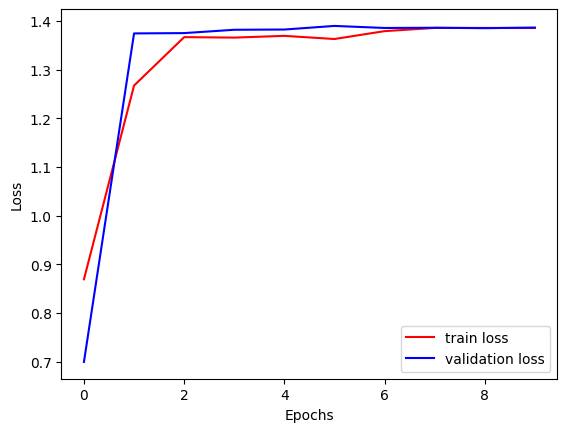

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

xrange = np.arange(10)
plt.plot(xrange, model.training_loss, 'r', label='train loss')
plt.plot(xrange, model.validation_loss, 'b', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from glob import glob

latest_ckpt = sorted(glob('./lightning_logs/version_2/checkpoints/*.ckpt'))[-1]
latest_ckpt

In [ ]:
model = Model.load_from_checkpoint(latest_ckpt)

In [ ]:
def infer(x):

    x_tokens = model.tokenizer(x, return_tensors='pt')
    x_tokens = x_tokens.to('cuda')

    return torch.softmax(
        model(**x_tokens
    ).logits, dim=-1)

In [ ]:
tokens = model.tokenizer('기분이 좋다', return_tensors='pt')
tokens = tokens.to('cuda')

In [ ]:
infer('부하직원이 있는데 너무 일도 잘하고 신뢰가 가.')

In [ ]:
infer('성가신 친구가 하나 있는데 너무 귀찮아.')